# CZII YOLO11 Training Baseline
 We created a training set adapted to YOLO from [the dataset baseline](https://www.kaggle.com/code/itsuki9180/czii-making-datasets-for-yolo).

In this notebook, we actually use it to train YOLO so that it can infer the xy coordinates of particles through 2D object detection.

# Install and Import modules

In [1]:
# !tar xfvz /kaggle/input/ultralytics-for-offline-install/archive.tar.gz
# !pip install --no-index --find-links=./packages ultralytics
# !rm -rf ./packages

In [2]:
EXP_NAME = "baseline_cv_syn_data_transfer_radius"
LIST_CV = [
    'TS_5_4',
    'TS_69_2',
    'TS_6_4',
    'TS_6_6',
    'TS_73_6',
    'TS_86_3',
    'TS_99_9',
]

PROC_RAW = "proc/yolo11_cv_adjust_radius"

PROC = f"../../{PROC_RAW}"
PROC_YAML = f"/workspace/CZII/{PROC_RAW}"

In [3]:
from tqdm import tqdm
import glob, os
from ultralytics import YOLO

# Prepare to train and instance YOLOmodel

In [4]:
yaml_content = f"""
train: {PROC_YAML}/train.txt
val: {PROC_YAML}/val.txt
nc: 6

# Classes
names:
  0: apo-ferritin
  1: beta-amylase
  2: beta-galactosidase
  3: ribosome
  4: thyroglobulin
  5: virus-like-particle
"""

with open(f'{PROC}/cv_conf.yaml', 'w') as f:
    f.write(yaml_content.strip())

# Let's train YOLO!

In [5]:
def list_all_images(root_dir, extensions="png"):
    """指定ディレクトリ以下の画像ファイルパスを再帰的に取得してリストで返す。"""
    all_paths = []
    search_pattern = os.path.join(root_dir, "**", f"*.{extensions}")
    paths = glob.glob(search_pattern, recursive=True)
    all_paths.extend(paths)
    return all_paths

def contains_val_keyword(path, keyword):
    """
    ファイルパスのファイル名に `keyword` が含まれているか確認。
    Trueならval、Falseならtrainとする。
    """
    filename = os.path.basename(path)  # ディレクトリを除いたファイル名を取得
    return keyword in filename

def extract_train_val_paths(keyword):

    image_paths = list_all_images(f"{PROC_YAML}/images")
    image_paths.sort()
    # print(image_paths)

    train_paths = []
    val_paths   = []

    # ファイル名をみて振り分け
    for p in image_paths:
        if contains_val_keyword(p, keyword):
            val_paths.append(p)
        else:
            train_paths.append(p)

    print(f"Found {len(train_paths)} train images.")
    print(f"Found {len(val_paths)} val images.")

    # train.txt と val.txt に書き出し
    with open(f"{PROC}/train.txt", "w") as f:
        for path in train_paths:
            f.write(path + "\n")

    with open(f"{PROC}/val.txt", "w") as f:
        for path in val_paths:
            f.write(path + "\n")

    print(f"Train list saved to {f"{PROC}/train.txt"}")
    print(f"Val list saved to {f"{PROC}/val.txt"}")

In [6]:
dir_name = "baseline_cv_syn_data_mod"
model_path = f"../../runs/detect/{dir_name}/weights/best.pt"


for cv_name in LIST_CV:
    print("="*100)
    print(f"Processing {cv_name}...")
    extract_train_val_paths(cv_name)

    # Load a pretrained model
    model = YOLO(model_path)  # load a pretrained model (recommended for training)

    # Train the model
    _ = model.train(
        data=f"{PROC}/cv_conf.yaml",
        name=EXP_NAME,
        epochs=25,
        warmup_epochs=3,
        optimizer='AdamW',
        cos_lr=True,
        lr0=5e-5,
        lrf=0.01,
        imgsz=640,
        device="0",
        weight_decay=0.01,
        batch=16,
        scale=0,
        flipud=0.5,
        fliplr=0.5,
        degrees=90,
        shear=5,
        mixup=0.2,
        copy_paste=0.25,
        seed=8620, # (｡•◡•｡)
    )

Processing TS_5_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt


New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
engine/trainer: task=detect, mode=train, model=../../runs/detect/baseline_cv_syn_data_mod/weights/best.pt, data=../../proc/yolo11_cv_adjust_radius/cv_conf.yaml, epochs=25, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=baseline_cv_syn_data_transfer_radius, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=8620, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 272 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 200.62it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.2' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 30 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 176.39it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(bed3e25b6a95405eaffdd9c03088d568) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25        11G       1.39      1.447      1.115        467        640: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2640      0.571      0.499       0.49      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25        11G      1.327      1.218      1.086        497        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2640       0.54      0.513      0.521      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25        11G      1.282      1.181       1.07        303        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.559      0.575       0.59      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25        11G      1.285      1.175      1.067        505        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.588      0.573      0.594      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25        11G      1.261      1.147      1.056        528        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2640      0.583      0.601      0.594      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25        11G      1.251      1.136      1.054        494        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.593      0.599      0.598      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25        11G       1.23      1.116       1.05        265        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.589      0.585        0.6      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25        11G      1.237      1.109      1.048        318        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.622      0.579      0.606      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      10.9G      1.227      1.104       1.04        326        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2640      0.609      0.589      0.606      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.1G      1.207      1.083      1.037        390        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.604      0.587      0.606        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25        11G      1.189      1.086      1.033        417        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.619      0.595       0.62      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25        11G      1.201      1.092      1.032        413        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640      0.609      0.592      0.619      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25        11G      1.196      1.067      1.029        626        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.78it/s]

                   all        184       2640      0.604      0.605      0.615      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25        11G      1.175      1.049      1.028        466        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.587      0.593      0.606      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.1G      1.179      1.061      1.027        331        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.592      0.599      0.607      0.404


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      10.9G      1.105     0.9965     0.9918        303        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.587      0.591      0.607      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      10.8G      1.103     0.9705     0.9898        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2640      0.604       0.59       0.61      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      10.9G      1.106      0.979     0.9909        448        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640      0.595      0.594       0.61      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25        11G      1.098      0.952     0.9892        282        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640      0.588      0.591       0.61      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      10.9G      1.086     0.9487     0.9827        368        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2640        0.6      0.597       0.61      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      10.9G      1.073      0.929     0.9834        338        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.605      0.601      0.612       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.1G      1.075     0.9333     0.9814        360        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.602      0.595      0.617      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25        11G       1.07     0.9312     0.9794        201        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.602      0.601      0.618      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      10.9G      1.077     0.9297     0.9826        218        640: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2640      0.603      0.605      0.617      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      10.9G      1.071     0.9299     0.9797        447        640: 100%|██████████| 69/69 [00:27<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2640      0.605      0.599      0.618      0.415



25 epochs completed in 0.224 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


                   all        184       2640      0.603      0.594      0.617      0.418
          apo-ferritin        133        506      0.674      0.733      0.752      0.466
    beta-galactosidase        112        200      0.379       0.25      0.258      0.155
              ribosome        145        899      0.684      0.753      0.775      0.515
         thyroglobulin        144        749      0.428      0.291      0.333      0.217
   virus-like-particle        105        286      0.852      0.944      0.966      0.735
Speed: 0.2ms preprocess, 23.4ms inference, 0.0ms loss, 12.9ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_69_2...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
N

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 220 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 197.87it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 82 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 181.13it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius2/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(eec8f633839a45bfbfc17f57115ac3d3) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius2
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.383      1.441      1.113        478        640: 100%|██████████| 69/69 [00:30<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.00it/s]

                   all        184       2814      0.575      0.496       0.51      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.6G      1.324      1.221      1.085        495        640: 100%|██████████| 69/69 [00:28<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.596       0.54      0.571      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G      1.283      1.181       1.07        274        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.599      0.567      0.592      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.285      1.184      1.067        514        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2814      0.598      0.583      0.603      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.265      1.144      1.056        529        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.634      0.617       0.62      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.245      1.136      1.053        454        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2814      0.622      0.591      0.601      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.229       1.12      1.049        254        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.603      0.603      0.601      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.231      1.104      1.047        316        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.628      0.614      0.628      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.227      1.101       1.04        331        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.603      0.631      0.618      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.206      1.096      1.037        374        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.606      0.611      0.606      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.192      1.084      1.034        427        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2814      0.613      0.607      0.613      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.197      1.091       1.03        408        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.605      0.628      0.615      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.204      1.071      1.031        598        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        184       2814      0.595      0.625      0.618      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.7G      1.182      1.058      1.029        460        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2814      0.633      0.606      0.618      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G      1.182      1.055      1.028        359        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2814      0.616      0.614      0.613       0.42


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.109     0.9928     0.9926        337        640: 100%|██████████| 69/69 [00:29<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       2814      0.617      0.626      0.618      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.4G      1.101     0.9675     0.9893        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        184       2814        0.6      0.638      0.616      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G        1.1     0.9671     0.9889        447        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814      0.614      0.628      0.622      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G        1.1     0.9437     0.9899        282        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.608      0.625      0.611      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      1.081     0.9369     0.9803        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.612      0.617      0.615      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.075     0.9284      0.984        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.606      0.626      0.614       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G      1.072     0.9201     0.9808        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.611      0.627      0.617      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.072     0.9229     0.9802        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.01it/s]

                   all        184       2814       0.61      0.631       0.62      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.073     0.9188      0.981        204        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.608      0.627      0.617      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.071     0.9211     0.9792        390        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2814      0.607      0.628      0.617      0.432



25 epochs completed in 0.225 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius2/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius2/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius2/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]


                   all        184       2814      0.602      0.631      0.616      0.443
          apo-ferritin         75        385      0.655      0.706      0.663      0.448
    beta-galactosidase         86        272      0.453      0.262      0.289      0.165
              ribosome         96       1073      0.793      0.829      0.883      0.632
         thyroglobulin        100        850      0.316      0.435      0.283      0.175
   virus-like-particle         56        234      0.792      0.923      0.961      0.797
Speed: 0.2ms preprocess, 7.4ms inference, 0.0ms loss, 21.1ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius2
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_4...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
Ne

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 200.34it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 176.57it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius3/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(1b1c889ff3d4423fb7d8a8524e1cef88) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius3
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.373      1.477      1.104        461        640: 100%|██████████| 69/69 [00:30<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998       0.51      0.458      0.443      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.5G      1.306      1.237      1.075        471        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.561      0.546      0.518      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.5G      1.278      1.209      1.064        258        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.523       0.56      0.537      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.269      1.183      1.057        446        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.557      0.578      0.553      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.5G      1.256      1.153      1.049        516        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.551      0.575      0.545       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.242      1.157      1.047        437        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.543      0.569      0.547      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.235      1.148      1.048        205        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.558       0.58      0.556       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G       1.22      1.126      1.039        312        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3998      0.519      0.567      0.548      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.218      1.112      1.034        306        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.547      0.572      0.551      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.7G      1.203      1.102      1.032        375        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.567      0.581      0.563      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.174      1.095      1.025        430        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.579      0.569      0.564      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.186      1.096      1.023        383        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.592       0.58       0.57      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.183      1.074      1.021        583        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.578      0.575      0.563      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.161      1.072      1.019        440        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       3998      0.554      0.584       0.56      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.6G      1.169      1.069       1.02        333        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.571      0.571      0.561      0.368


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.093      1.006     0.9847        326        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.584      0.569      0.568      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.091     0.9818     0.9839        370        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       3998      0.575      0.579      0.573      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G      1.083     0.9758     0.9805        440        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.568      0.595       0.57       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.087     0.9594     0.9832        259        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.571       0.59      0.567      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G      1.069     0.9508      0.975        339        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.575      0.581       0.57      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.063      0.946     0.9771        336        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3998      0.591      0.587      0.574      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G       1.06     0.9365     0.9736        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3998      0.608      0.569      0.576      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.056     0.9315     0.9722        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3998      0.602      0.583      0.577      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.059     0.9295     0.9747        191        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998      0.596      0.589      0.577       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.057     0.9303     0.9721        362        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3998        0.6      0.586      0.576       0.38



25 epochs completed in 0.225 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius3/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius3/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius3/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.68s/it]


                   all        184       3998      0.602      0.583      0.577      0.382
          apo-ferritin        121        638      0.703      0.756      0.775      0.502
    beta-galactosidase         89        204       0.48      0.225      0.258      0.138
              ribosome        129       2146      0.652      0.853      0.764      0.488
         thyroglobulin        125        750      0.405      0.387      0.345        0.2
   virus-like-particle         75        260       0.77      0.694      0.743       0.58
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius3
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_6_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
New

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 278 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 201.53it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache



/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 24 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 171.19it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius4/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(725d3b0dc9704acb90ccc9182c5866c6) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius4
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.395      1.456      1.117        529        640: 100%|██████████| 69/69 [00:30<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.92it/s]

                   all        184       2674      0.519      0.426      0.475      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.7G      1.319      1.221      1.084        491        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2674      0.562      0.548      0.561      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G       1.29      1.205      1.072        261        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.552      0.595      0.571      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.278      1.182      1.064        461        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.566       0.61      0.589      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.253      1.139      1.053        541        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       2674      0.561      0.587      0.591      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.245      1.152      1.052        474        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2674      0.608      0.576      0.593       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.228       1.13      1.049        221        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.594      0.597      0.601      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.219      1.099      1.042        314        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2674      0.614      0.584      0.609      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.224      1.104       1.04        382        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.586      0.609      0.606      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.206      1.077      1.038        384        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.568      0.621       0.61      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.178      1.078      1.031        471        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.589      0.612      0.613      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.191      1.088      1.029        421        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.623      0.634      0.623       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.193      1.066      1.029        612        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674       0.62      0.608      0.616      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.166      1.056      1.024        482        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2674      0.608      0.602      0.618      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G      1.177      1.054      1.026        331        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.604      0.614      0.625      0.413


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.102     0.9945     0.9912        326        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2674      0.591      0.617      0.618      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.094      0.965     0.9874        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.582      0.621      0.622       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.5G      1.088      0.966     0.9837        437        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.633      0.597      0.625      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.095     0.9465     0.9891        259        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       2674      0.617      0.599      0.624      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.5G      1.078      0.944     0.9817        363        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.562      0.634      0.614      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.068     0.9294     0.9825        332        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.90it/s]

                   all        184       2674       0.57      0.617      0.614      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G      1.069     0.9306     0.9785        366        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.576      0.625      0.616      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.063     0.9238     0.9769        226        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.89it/s]

                   all        184       2674      0.574      0.627      0.618      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.066     0.9158     0.9801        214        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.577      0.623       0.62      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.063     0.9156     0.9762        394        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       2674      0.573      0.629      0.619      0.412



25 epochs completed in 0.247 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius4/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius4/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius4/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


                   all        184       2674      0.621      0.597      0.624      0.421
          apo-ferritin        149        451      0.679      0.707      0.721      0.502
    beta-galactosidase         84        187       0.38      0.241      0.294      0.178
              ribosome        106        667      0.825      0.826      0.879      0.507
         thyroglobulin        144        875       0.38      0.311      0.283      0.172
   virus-like-particle        127        494      0.838      0.901      0.942      0.744
Speed: 0.2ms preprocess, 16.7ms inference, 0.0ms loss, 19.8ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius4
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_73_6...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt


train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 198.10it/s]


train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 174.08it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius5/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(7c2f9840eac74353a989b38de0609ea6) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius5
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.394      1.477      1.119        507        640: 100%|██████████| 69/69 [00:29<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       3860      0.522      0.454      0.463      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.8G      1.328      1.236      1.087        446        640: 100%|██████████| 69/69 [00:28<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.88it/s]

                   all        184       3860      0.495      0.559      0.514      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.277      1.205      1.068        253        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860      0.514      0.544      0.531      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.6G      1.276       1.18      1.065        428        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       3860      0.555      0.581      0.557      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G       1.27      1.155      1.058        506        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.517      0.565      0.547      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.248      1.146      1.053        457        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       3860      0.548      0.586      0.558      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.7G      1.224      1.125      1.049        203        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860       0.52      0.585      0.554      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.227      1.113      1.045        267        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860      0.552      0.581       0.56       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.238      1.115      1.046        392        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.557       0.58      0.571      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.216      1.091      1.042        379        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.547      0.577      0.563      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.6G      1.194      1.086      1.036        418        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860       0.55      0.593      0.569      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G        1.2      1.096      1.033        338        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.536      0.595      0.573       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.203      1.082      1.035        565        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.537      0.595      0.561      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G       1.18      1.078       1.03        446        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3860      0.539      0.592      0.565      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.9G      1.182      1.063      1.029        311        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.87it/s]

                   all        184       3860       0.54      0.602      0.569       0.39


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.117      1.014      0.997        300        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       3860      0.552      0.574      0.564      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.102     0.9753     0.9905        352        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860      0.544      0.594      0.568      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G      1.098     0.9745     0.9871        438        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860      0.547      0.606      0.571      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.6G      1.097     0.9537     0.9909        234        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860      0.537      0.596      0.567      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      1.091     0.9523     0.9856        344        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860      0.541      0.589      0.566      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.079     0.9373     0.9873        281        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       3860      0.544      0.606       0.57      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.7G       1.08     0.9383      0.983        337        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       3860      0.535      0.609      0.569      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.078      0.932      0.982        207        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860       0.55      0.601      0.572      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.075     0.9275     0.9843        214        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860       0.55      0.602      0.572      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.067     0.9203     0.9795        396        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       3860      0.543      0.603      0.572      0.398



25 epochs completed in 0.247 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius5/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius5/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius5/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.78s/it]


                   all        184       3860      0.547      0.606      0.572      0.398
          apo-ferritin        137       1036      0.564      0.727      0.658      0.442
    beta-galactosidase         97        238      0.342      0.311      0.283      0.156
              ribosome        145       1328      0.653      0.844       0.81      0.538
         thyroglobulin        142        694      0.256      0.298      0.178      0.111
   virus-like-particle        114        564      0.921      0.851       0.93      0.745
Speed: 0.2ms preprocess, 21.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius5
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_86_3...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
N

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 253 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 200.25it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 49 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 174.44it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius6/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(a68d1e05c09945c49c3567827aa3ae5b) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius6
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.384      1.498      1.112        490        640: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.86it/s]

                   all        184       4569      0.558      0.445      0.494      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.7G      1.316      1.252      1.083        386        640: 100%|██████████| 69/69 [00:28<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4569      0.612      0.601      0.598      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.6G      1.274      1.229      1.064        260        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4569       0.64      0.602      0.622      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.5G      1.267      1.206      1.057        367        640: 100%|██████████| 69/69 [00:28<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.40it/s]

                   all        184       4569      0.602      0.663      0.631      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.259      1.181      1.051        480        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       4569      0.644      0.637      0.637      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.239      1.173      1.047        486        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4569      0.662      0.623      0.629      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.218      1.149      1.045        203        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.639      0.633      0.645      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G       1.22      1.133       1.04        261        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4569      0.645      0.641      0.643      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G      1.227      1.144      1.041        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.629      0.649      0.644      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.8G      1.208      1.124      1.038        384        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.644      0.638      0.635       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.7G      1.186      1.111      1.031        427        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4569      0.623      0.652      0.631      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.5G      1.194      1.126      1.029        361        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4569      0.639      0.651      0.647      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.197      1.101      1.029        505        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4569      0.645      0.627      0.643      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.6G      1.174      1.087      1.026        466        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4569      0.646      0.634      0.645      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.6G      1.172      1.077       1.02        340        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.649      0.641      0.646      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.5G      1.098      1.014      0.988        252        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       4569       0.65      0.636      0.646      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.5G      1.091      0.986     0.9855        298        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4569      0.647      0.635      0.645      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G      1.085     0.9796     0.9812        366        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.663      0.635      0.644      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.5G      1.076     0.9561     0.9827        233        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4569      0.673      0.635      0.644      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      1.074     0.9565     0.9792        308        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569       0.67      0.626      0.645      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.065     0.9441     0.9814        294        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.666      0.634      0.646       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G      1.066     0.9402     0.9754        310        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4569      0.665      0.628      0.644      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.062      0.932     0.9735        185        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]

                   all        184       4569      0.668      0.632      0.644      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.5G      1.059     0.9272      0.977        200        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.84it/s]

                   all        184       4569       0.67      0.625      0.644      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.5G      1.055     0.9268     0.9744        384        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4569      0.664      0.632      0.643       0.43



25 epochs completed in 0.250 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius6/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius6/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius6/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.70s/it]


                   all        184       4569      0.664      0.635      0.644      0.438
          apo-ferritin         98        704      0.714      0.747       0.77      0.533
    beta-galactosidase         87        391      0.546      0.289       0.38      0.216
              ribosome        101       1595      0.748      0.858      0.812      0.505
         thyroglobulin        135       1125      0.365      0.383      0.297      0.167
   virus-like-particle         89        754      0.945      0.897       0.96      0.771
Speed: 0.2ms preprocess, 6.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius6
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Processing TS_99_9...
Found 1104 train images.
Found 184 val images.
Train list saved to ../../proc/yolo11_cv_adjust_radius/train.txt
Val list saved to ../../proc/yolo11_cv_adjust_radius/val.txt
Ne

train: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 1104 images, 263 backgrounds, 0 corrupt: 100%|██████████| 1104/1104 [00:05<00:00, 196.64it/s]

train: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),
val: Scanning /workspace/CZII/proc/yolo11_cv_adjust_radius/labels... 184 images, 39 backgrounds, 0 corrupt: 100%|██████████| 184/184 [00:01<00:00, 173.65it/s]

val: New cache created: /workspace/CZII/proc/yolo11_cv_adjust_radius/labels.cache


Plotting labels to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius7/labels.jpg... 
optimizer: AdamW(lr=5e-05, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.01), 173 bias(decay=0.0)
MLflow: logging run_id(f0d641a83ed849ed9654eddac381cbc7) to /workspace/CZII/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /workspace/CZII/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius7
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      11.6G      1.392      1.451      1.113        491        640: 100%|██████████| 69/69 [00:31<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       4244      0.541      0.438      0.496      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      11.5G      1.319      1.224      1.081        370        640: 100%|██████████| 69/69 [00:29<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        184       4244      0.562       0.51       0.54      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      11.7G      1.277      1.197      1.061        254        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4244      0.584      0.571      0.576      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      11.5G      1.266      1.176      1.056        380        640: 100%|██████████| 69/69 [00:27<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.76it/s]

                   all        184       4244      0.538       0.59      0.572      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      11.6G      1.261      1.153       1.05        495        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.77it/s]

                   all        184       4244      0.565      0.585      0.583      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      11.6G      1.252      1.161      1.051        467        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.69it/s]

                   all        184       4244      0.603      0.576      0.586      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      11.6G      1.232      1.138      1.046        212        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4244      0.587      0.584      0.587      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      11.6G      1.228      1.112      1.041        252        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.576      0.583      0.582       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      11.6G       1.24      1.116      1.045        404        640: 100%|██████████| 69/69 [00:28<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.55it/s]

                   all        184       4244      0.608      0.579      0.598      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      11.6G       1.22      1.108      1.041        357        640: 100%|██████████| 69/69 [00:28<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4244      0.611      0.569      0.594      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      11.7G      1.186      1.068       1.03        456        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4244      0.585      0.574      0.587      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      11.6G      1.202      1.111       1.03        356        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.85it/s]

                   all        184       4244      0.603      0.594      0.603      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      11.6G      1.204      1.076       1.03        413        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]

                   all        184       4244      0.585      0.594      0.603      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      11.5G      1.181      1.067      1.028        451        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.577      0.594      0.595      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      11.7G      1.177      1.061       1.02        285        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.588      0.601      0.599      0.418


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/workspace/CZII/.venv/lib/python3.12/site-packages/ultralytics/data/augment.py:1850: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=75, p=0.0),



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      11.6G      1.105     0.9839     0.9891        278        640: 100%|██████████| 69/69 [00:28<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.79it/s]

                   all        184       4244      0.604      0.589        0.6      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      11.6G        1.1     0.9616     0.9864        348        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.71it/s]

                   all        184       4244      0.588       0.59      0.594      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      11.6G      1.094     0.9546     0.9841        374        640: 100%|██████████| 69/69 [00:27<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.596      0.602      0.602      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      11.5G      1.084     0.9412      0.984        267        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.584      0.609      0.604      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      11.6G      1.083      0.937     0.9818        330        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.81it/s]

                   all        184       4244      0.593      0.599      0.603      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      11.5G      1.073     0.9285     0.9826        330        640: 100%|██████████| 69/69 [00:27<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4244      0.604      0.587      0.602      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      11.6G      1.074     0.9198     0.9792        294        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244      0.591      0.597      0.602      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      11.6G      1.074     0.9183     0.9767        220        640: 100%|██████████| 69/69 [00:27<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4244      0.591      0.591      0.599       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      11.6G      1.069     0.9148      0.979        188        640: 100%|██████████| 69/69 [00:27<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.80it/s]

                   all        184       4244        0.6      0.589      0.602      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      11.6G      1.066     0.9156     0.9766        377        640: 100%|██████████| 69/69 [00:27<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.82it/s]

                   all        184       4244      0.583      0.598      0.599      0.419



25 epochs completed in 0.250 hours.
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius7/weights/last.pt, 51.2MB
Optimizer stripped from /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius7/weights/best.pt, 51.2MB

Validating /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius7/weights/best.pt...
Ultralytics 8.3.53 🚀 Python-3.12.8 torch-2.5.1+cu124 CUDA:0 (NVIDIA RTX A4000, 16102MiB)
YOLO11l summary (fused): 464 layers, 25,283,938 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:10<00:00,  1.73s/it]


                   all        184       4244      0.597      0.602      0.602      0.432
          apo-ferritin        109        396      0.611      0.798      0.778      0.562
    beta-galactosidase        106        408      0.358      0.206      0.196      0.102
              ribosome        145       1883      0.772      0.738      0.783      0.529
         thyroglobulin        144       1219      0.371      0.338      0.293      0.184
   virus-like-particle         81        338      0.873      0.932      0.958      0.784
Speed: 0.2ms preprocess, 6.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /workspace/CZII/runs/detect/baseline_cv_syn_data_transfer_radius7
MLflow: results logged to /workspace/CZII/runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [7]:
# model = YOLO(f"../../runs/detect/{EXP_NAME}/weights/best.pt")
# metrics = model.val(data=f"{PROC}/czii_conf.yaml", imgsz=640, batch=16, conf=0.25, iou=0.6, device="0", save_json=True)  # no arguments needed, dataset and settings remembered
# print(metrics.box.map)  # map50-95
# print(metrics.box.map50)  # map50
# print(metrics.box.map75)  # map75
# print(metrics.box.maps)

# Prediction example

In [8]:
import pandas as pd
from IPython.display import display, HTML
from IPython.display import Image as IPyImage
pd.options.display.precision = 3

columns = [
    "metrics/precision(B)",
    "metrics/recall(B)",
    "metrics/mAP50(B)",
    "metrics/mAP50-95(B)",
]
df_result = pd.DataFrame(columns=columns)
for i in range(len(LIST_CV)):
    if i == 0:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}/results.csv")
    else:
        df = pd.read_csv(f"../../runs/detect/{EXP_NAME}{i+1}/results.csv")
    
    list_results = [
        df.iloc[-1]["metrics/precision(B)"],
        df.iloc[-1]["metrics/recall(B)"],
        df.iloc[-1]["metrics/mAP50(B)"],
        df.iloc[-1]["metrics/mAP50-95(B)"],
    ]
    df_result.loc[f"val_{LIST_CV[i]}"] = list_results
df_result.loc["mean"] = df_result.mean()
df_result

,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B)
val_TS_5_4,0.605,0.599,0.618,0.415
val_TS_69_2,0.607,0.628,0.617,0.432
val_TS_6_4,0.600,0.586,0.576,0.380
val_TS_6_6,0.573,0.629,0.619,0.412
val_TS_73_6,0.543,0.603,0.572,0.398
val_TS_86_3,0.664,0.632,0.643,0.430
val_TS_99_9,0.583,0.598,0.599,0.419
mean,0.597,0.611,0.606,0.412


In [9]:
# 画像を2x2のグリッドで表示
html_content = '''
<div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
    <img src="../../runs/detect/{}/PR_curve.png" style="width: 80%;">
</div>
'''.format(
    EXP_NAME,
    f"{EXP_NAME}2",
    f"{EXP_NAME}3",
    f"{EXP_NAME}4"
)

display(HTML(html_content))

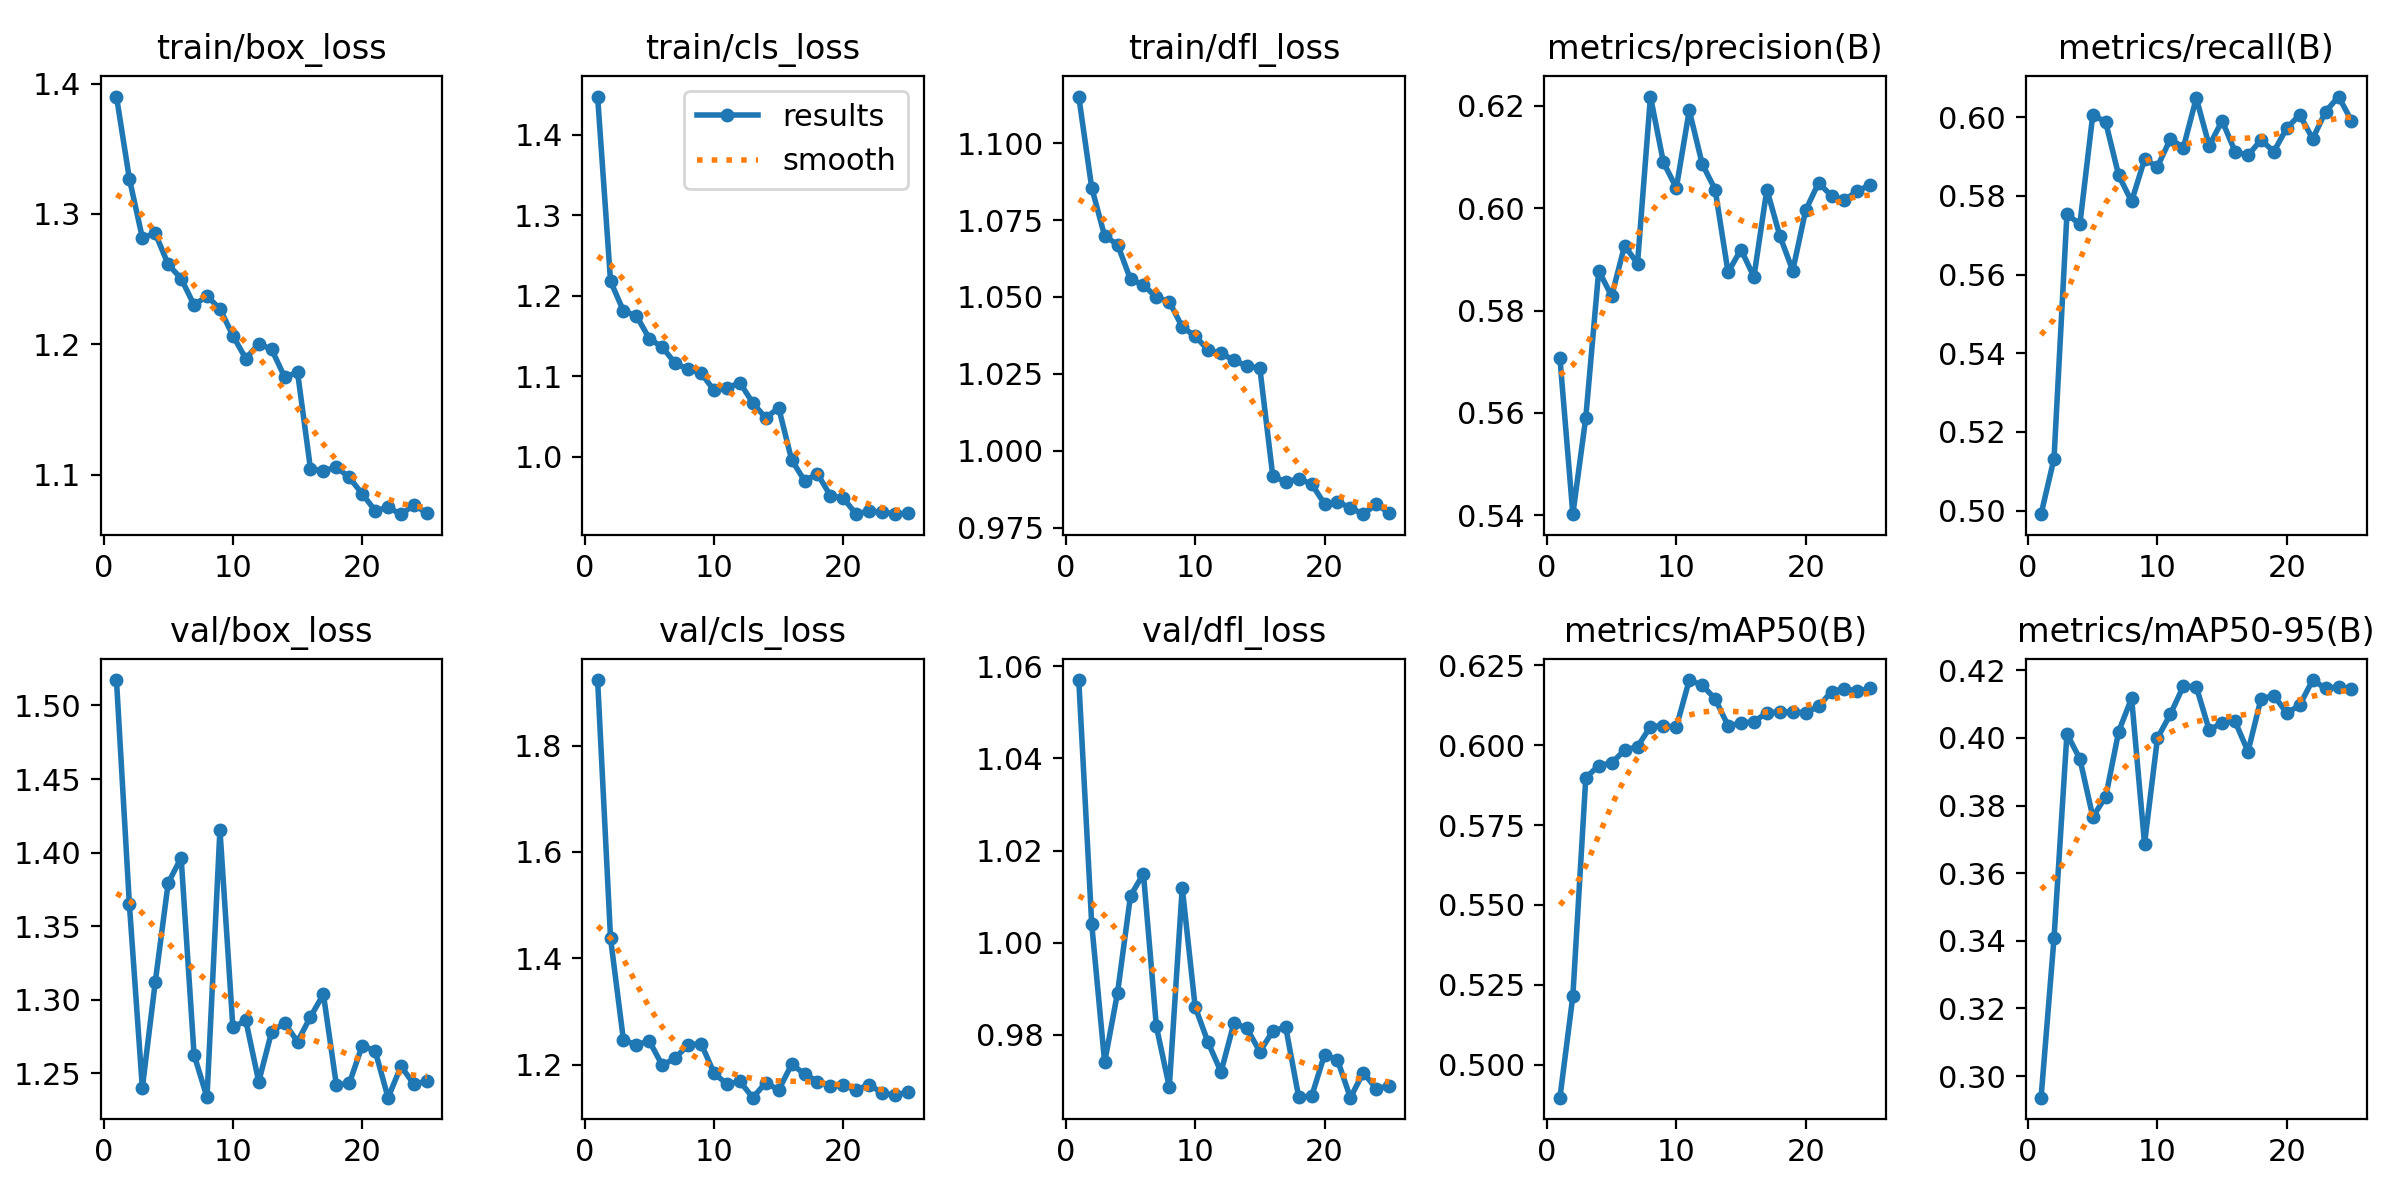

In [10]:
IPyImage(filename=f'../../runs/detect/{EXP_NAME}/results.png', width=800)